In [23]:
import os
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
import codecs
import csv
from multiprocessing import Process# this isused for multithreading
import multiprocessing 
import random as r
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import random
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
import dask.array as da
import dask.distributed
import pickle
import pandas.util.testing as tm
from sklearn.metrics import log_loss

In [13]:
bigram_vocab=list(pd.read_csv('bigram_vocab.txt',delimiter=',',header=None, dtype=str).to_numpy()[0])

In [3]:
'''bytebigram_vect = scipy.sparse.csr_matrix((10,20))
type(random.sample(os.listdir('byteFiles_train'), len(os.listdir('byteFiles_train'))))'''

list

In [9]:
#creating BOW of 2-gram data
import random
file_names=[]
vector = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=bigram_vocab)
bytebigram_vect = scipy.sparse.csr_matrix((2001, len(bigram_vocab)))
for i, file in tqdm(enumerate(random.sample(os.listdir('byteFiles_train'),len(os.listdir('byteFiles_train'))))):
    if file.endswith('.bytes'):
        name=file.split('.')[0]
        f = open('byteFiles_train/' + file)
        bytebigram_vect[i]=scipy.sparse.csr_matrix(vector.transform([f.read().replace('\n', ' ').upper()]))
        file_names.append(file)
        if i==2000:
            break;

2000it [1:24:00,  2.52s/it]


In [18]:
'''import pickle
with open('Bigram_BOW_Vectors.pkl','wb') as f:
    pickle.dump(bytebigram_vect, f)
with open('file_names.pkl','wb') as f:
    pickle.dump(file_names, f)'''

In [2]:
with open('Bigram_BOW_Vectors.pkl','rb') as fe_data_file:
    Bigram_BOW_Vectors=pickle.load(fe_data_file)
with open('file_names.pkl','rb') as fe_data_file:
    file_names=pickle.load(fe_data_file)

In [3]:
Bigram_BOW_Vectors

<2001x70226 sparse matrix of type '<class 'numpy.float64'>'
	with 91222950 stored elements in Compressed Sparse Row format>

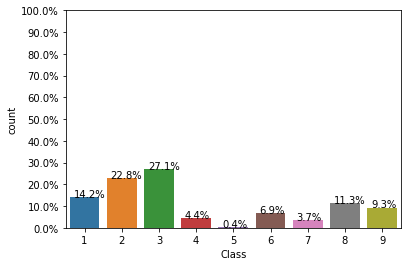

In [4]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [5]:
list_of_files=file_names
train=[]

for files in list_of_files:
    train.append(files.split('.')[0])

class_detail=pd.read_csv('trainLabels.csv', delimiter=',')
class_detail.shape

train_class=[]
for values in tqdm(train):
    train_class.append(int(class_detail[class_detail['Id']==values]['Class']))

100%|█████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:03<00:00, 528.28it/s]


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_class)

In [7]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5],
    'subsample':[0.1,0.3,0.5]
}

random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10)
random_cfl1.fit(Bigram_BOW_Vectors,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 1/10] END colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3;, score=0.970 total time= 3.9min
[CV 2/5; 1/10] START colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 1/10] END colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3;, score=0.978 total time= 3.6min
[CV 3/5; 1/10] START colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 1/10] END colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3;, score=0.970 total time= 3.5min
[CV 4/5; 1/10] START colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 1/10] END colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3;, score=0.985 total time= 3.6min
[CV 5/5; 1/10] START colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 1/10] END colsample_bytree=0.1, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3;, score=0.983 total time= 3.6min
[CV 1/5; 2/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 2/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5;, score=0.975 total time=10.5min
[CV 2/5; 2/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 2/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5;, score=0.983 total time=10.5min
[CV 3/5; 2/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 2/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5;, score=0.973 total time=10.6min
[CV 4/5; 2/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 2/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5;, score=0.990 total time=10.7min
[CV 5/5; 2/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 2/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=10, n_estimators=200, subsample=0.5;, score=0.985 total time=10.7min
[CV 1/5; 3/10] START colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 3/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1;, score=0.948 total time= 6.5min
[CV 2/5; 3/10] START colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 3/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1;, score=0.943 total time= 6.5min
[CV 3/5; 3/10] START colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 3/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1;, score=0.945 total time= 6.4min
[CV 4/5; 3/10] START colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 3/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1;, score=0.955 total time= 6.5min
[CV 5/5; 3/10] START colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 3/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.1;, score=0.963 total time= 6.5min
[CV 1/5; 4/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 4/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5;, score=0.975 total time=16.9min
[CV 2/5; 4/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:26:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 4/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5;, score=0.985 total time=17.0min
[CV 3/5; 4/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 4/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5;, score=0.975 total time=16.8min
[CV 4/5; 4/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:00:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 4/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5;, score=0.990 total time=17.3min
[CV 5/5; 4/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 4/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.5;, score=0.985 total time=17.3min
[CV 1/5; 5/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 5/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5;, score=0.975 total time=11.3min
[CV 2/5; 5/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 5/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5;, score=0.983 total time=11.3min
[CV 3/5; 5/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:57:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 5/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5;, score=0.978 total time=11.3min
[CV 4/5; 5/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:08:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 5/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5;, score=0.990 total time=11.5min
[CV 5/5; 5/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 5/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5;, score=0.985 total time=11.5min
[CV 1/5; 6/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 6/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1;, score=0.963 total time=13.5min
[CV 2/5; 6/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:45:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 6/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1;, score=0.973 total time=13.5min
[CV 3/5; 6/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 6/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1;, score=0.960 total time=13.4min
[CV 4/5; 6/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 6/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1;, score=0.973 total time=13.6min
[CV 5/5; 6/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:25:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 6/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.1;, score=0.973 total time=13.5min
[CV 1/5; 7/10] START colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 7/10] END colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5;, score=0.975 total time= 3.8min
[CV 2/5; 7/10] START colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 7/10] END colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5;, score=0.988 total time= 3.8min
[CV 3/5; 7/10] START colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:46:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 7/10] END colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5;, score=0.973 total time= 3.8min
[CV 4/5; 7/10] START colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 7/10] END colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5;, score=0.990 total time= 3.8min
[CV 5/5; 7/10] START colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 7/10] END colsample_bytree=0.1, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.5;, score=0.983 total time= 3.8min
[CV 1/5; 8/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 8/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3;, score=0.970 total time= 7.7min
[CV 2/5; 8/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 8/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3;, score=0.975 total time= 7.7min
[CV 3/5; 8/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 8/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3;, score=0.970 total time= 7.7min
[CV 4/5; 8/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 8/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3;, score=0.975 total time= 7.8min
[CV 5/5; 8/10] START colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 8/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.3;, score=0.980 total time= 7.8min
[CV 1/5; 9/10] START colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 9/10] END colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5;, score=0.973 total time= 3.3min
[CV 2/5; 9/10] START colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 9/10] END colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5;, score=0.980 total time= 3.3min
[CV 3/5; 9/10] START colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 9/10] END colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5;, score=0.975 total time= 3.3min
[CV 4/5; 9/10] START colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:46:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 9/10] END colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5;, score=0.990 total time= 3.4min
[CV 5/5; 9/10] START colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 9/10] END colsample_bytree=0.1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5;, score=0.980 total time= 3.3min
[CV 1/5; 10/10] START colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5; 10/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1;, score=0.970 total time= 9.1min
[CV 2/5; 10/10] START colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:02:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5; 10/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1;, score=0.968 total time= 8.9min
[CV 3/5; 10/10] START colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:11:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5; 10/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1;, score=0.953 total time= 8.9min
[CV 4/5; 10/10] START colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5; 10/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1;, score=0.978 total time= 9.0min
[CV 5/5; 10/10] START colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5; 10/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.1;, score=0.968 total time= 9.0min


C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=Non

In [10]:
pd.DataFrame(random_cfl1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,216.431162,9.358935,0.353105,0.105327,0.3,200,5,0.15,0.1,"{'subsample': 0.3, 'n_estimators': 200, 'max_d...",0.970075,0.9775,0.9700,0.9850,0.9825,0.977015,0.006188,6
1,634.950581,4.831496,0.321854,0.044849,0.5,200,10,0.15,0.3,"{'subsample': 0.5, 'n_estimators': 200, 'max_d...",0.975062,0.9825,0.9725,0.9900,0.9850,0.981012,0.006430,4
2,388.345574,1.801027,0.300310,0.006907,0.1,100,5,0.05,0.5,"{'subsample': 0.1, 'n_estimators': 100, 'max_d...",0.947631,0.9425,0.9450,0.9550,0.9625,0.950526,0.007304,10
3,1023.654483,11.751223,0.287481,0.007655,0.5,200,5,0.05,0.3,"{'subsample': 0.5, 'n_estimators': 200, 'max_d...",0.975062,0.9850,0.9750,0.9900,0.9850,0.982012,0.005985,1
4,684.127961,6.289563,0.293720,0.011694,0.5,200,3,0.1,0.3,"{'subsample': 0.5, 'n_estimators': 200, 'max_d...",0.975062,0.9825,0.9775,0.9900,0.9850,0.982012,0.005322,1
5,808.397487,3.366739,0.303098,0.007658,0.1,500,5,0.05,0.3,"{'subsample': 0.1, 'n_estimators': 500, 'max_d...",0.962594,0.9725,0.9600,0.9725,0.9725,0.968019,0.005549,8
6,226.561200,1.023575,0.281229,0.009883,0.5,200,5,0.2,0.1,"{'subsample': 0.5, 'n_estimators': 200, 'max_d...",0.975062,0.9875,0.9725,0.9900,0.9825,0.981512,0.006807,3
7,464.810097,3.312047,0.281229,0.009884,0.3,100,5,0.05,0.3,"{'subsample': 0.3, 'n_estimators': 100, 'max_d...",0.970075,0.9750,0.9700,0.9750,0.9800,0.974015,0.003726,7
8,198.697256,1.702082,0.281221,0.000010,0.5,100,5,0.1,0.1,"{'subsample': 0.5, 'n_estimators': 100, 'max_d...",0.972569,0.9800,0.9750,0.9900,0.9800,0.979514,0.005984,5
9,539.039302,3.445117,0.293719,0.011696,0.1,200,10,0.1,0.5,"{'subsample': 0.1, 'n_estimators': 200, 'max_d...",0.970075,0.9675,0.9525,0.9775,0.9675,0.967015,0.008130,9


In [8]:
random_cfl1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
clf=XGBClassifier(learning_rate=0.05, n_estimators=200,max_depth=5, colsample_bytree=0.3 )
clf.fit(Bigram_BOW_Vectors,y_train)

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:53:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
top_features=np.argsort(clf.feature_importances_)
sorted_top_features=[bigram_vocab[i] for i in top_features]

In [15]:
with open('sorted_top_features.pkl','wb') as wr:
    pickle.dump(sorted_top_features, wr)

In [25]:
pred=clf.predict_proba(Bigram_BOW_Vectors)
loss=log_loss(y_train,pred)

In [27]:
loss

0.003193845667999409